<a href="https://colab.research.google.com/github/khalidpark/project-RNN/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
df1 = pd.read_csv('/content/실제진료정보_감기_시군구.csv', encoding='cp949')
df2 = pd.read_csv('/content/실제진료정보_눈병_시군구.csv', encoding='cp949')
df3 = pd.read_csv('/content/실제진료정보_천식_시군구.csv', encoding='cp949')
df4 = pd.read_csv('/content/실제진료정보_피부염_시군구.csv', encoding='cp949')

In [9]:
df1.head()

,날짜,시군구지역코드,발생건수(건)
0,20140101,11110,53
1,20140101,11140,55
2,20140101,11170,120
3,20140101,11200,192
4,20140101,11215,165


In [11]:
df2.head()

,날짜,시군구지역코드,발생건수(건)
0,20140101,11110,2
1,20140101,11140,1
2,20140101,11170,7
3,20140101,11200,9
4,20140101,11215,6


In [3]:
df = pd.concat([df1,df2['발생건수(건)'],df3['발생건수(건)'],df4['발생건수(건)']],axis=1)

In [13]:
df.head(10)

,날짜,시군구지역코드,발생건수(건),발생건수(건),발생건수(건),발생건수(건)
0,20140101,11110,53,2.0,7.0,4.0
1,20140101,11140,55,1.0,7.0,3.0
2,20140101,11170,120,7.0,11.0,2.0
3,20140101,11200,192,9.0,18.0,7.0
4,20140101,11215,165,6.0,17.0,5.0
5,20140101,11230,156,8.0,22.0,11.0
6,20140101,11260,211,7.0,26.0,13.0
7,20140101,11290,174,9.0,35.0,11.0
8,20140101,11305,185,10.0,69.0,10.0
9,20140101,11320,204,22.0,43.0,4.0


In [4]:
df.columns = ['Date','Code','Cold','Eye','Asthma','Dermatitis']

In [15]:
df.head()

,Date,Code,Cold,Eye,Asthma,Dermatitis
0,20140101,11110,53,2.0,7.0,4.0
1,20140101,11140,55,1.0,7.0,3.0
2,20140101,11170,120,7.0,11.0,2.0
3,20140101,11200,192,9.0,18.0,7.0
4,20140101,11215,165,6.0,17.0,5.0


In [16]:
df.shape

(619030, 6)

In [17]:
df.dtypes

Date            int64
Code            int64
Cold            int64
Eye           float64
Asthma        float64
Dermatitis    float64
dtype: object

In [5]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')

In [19]:
df.dtypes

Date          datetime64[ns]
Code                   int64
Cold                   int64
Eye                  float64
Asthma               float64
Dermatitis           float64
dtype: object

In [20]:
df.head(10)

,Date,Code,Cold,Eye,Asthma,Dermatitis
0,2014-01-01,11110,53,2.0,7.0,4.0
1,2014-01-01,11140,55,1.0,7.0,3.0
2,2014-01-01,11170,120,7.0,11.0,2.0
3,2014-01-01,11200,192,9.0,18.0,7.0
4,2014-01-01,11215,165,6.0,17.0,5.0
5,2014-01-01,11230,156,8.0,22.0,11.0
6,2014-01-01,11260,211,7.0,26.0,13.0
7,2014-01-01,11290,174,9.0,35.0,11.0
8,2014-01-01,11305,185,10.0,69.0,10.0
9,2014-01-01,11320,204,22.0,43.0,4.0




---



데이터는 하루마다 기록됩니다

특정 요일이 주어졌을때 앞으로 7일 동안의 발생건수를 예측한다고 가정해봅니다

예측을 하기 위해 6일간의 데이터를 사용하도록 합니다

모형을 학습하기 위해 30(6*5) 개의 관측값이 포함된 window를 만듭니다

In [14]:
def cold_data_funciton(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [6]:
TRAIN_SPLIT = 400000
# 재현성을 보장하기 위해 시드 설정.
tf.random.set_seed(13)



---



# 예측1) 감기 시계열 예측

In [23]:
cold_data = df['Cold']
cold_data.index = df['Date']
cold_data.head()

Date
2014-01-01     53
2014-01-01     55
2014-01-01    120
2014-01-01    192
2014-01-01    165
Name: Cold, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f37a5208a10>],
      dtype=object)

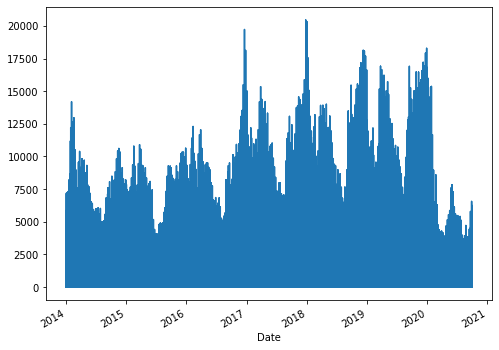

In [24]:
cold_data.plot(subplots=True)

In [25]:
cold_data = cold_data.values


In [26]:
cold_train_mean = cold_data[:TRAIN_SPLIT].mean()
cold_train_std = cold_data[:TRAIN_SPLIT].std()
# 데이터를 표준화합시다.
cold_data = (cold_data-cold_train_mean)/cold_train_std

In [27]:
cold_past_history = 20
cold_future_target = 0

x_train_cold, y_train_cold = cold_data_funciton(cold_data, 0, TRAIN_SPLIT,
                                           cold_past_history,
                                           cold_future_target)
x_val_cold, y_val_cold = cold_data_funciton(cold_data, TRAIN_SPLIT, None,
                                       cold_past_history,
                                       cold_future_target)


In [28]:
print ('Single window of past history')
print (x_train_cold[0])
print ('\n Target temperature to predict')
print (y_train_cold[0])

Single window of past history
[[-0.92588852]
 [-0.92466567]
 [-0.88492282]
 [-0.84089997]
 [-0.85740854]
 [-0.86291139]
 [-0.82928283]
 [-0.85190568]
 [-0.84517997]
 [-0.83356283]
 [-0.64524286]
 [-0.76324855]
 [-0.84395711]
 [-0.81093997]
 [-0.75040856]
 [-0.62078572]
 [-0.73817999]
 [-0.86657996]
 [-0.84212283]
 [-0.82133426]]

 Target temperature to predict
-0.7815914073552783


In [24]:
def create_time_steps(length):
  return list(range(-length, 0))

In [30]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

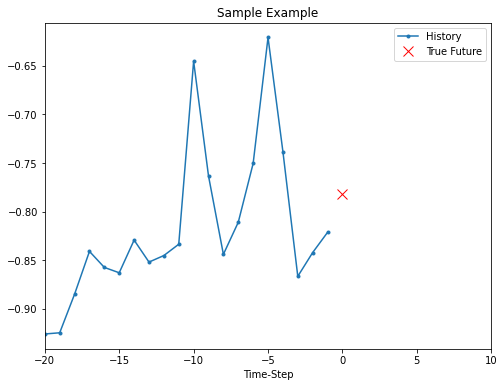

In [31]:
show_plot([x_train_cold[0], y_train_cold[0]], 0, 'Sample Example')

In [32]:
def baseline(history):
  return np.mean(history)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

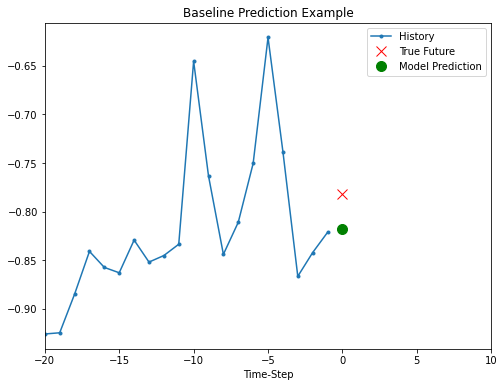

In [33]:
show_plot([x_train_cold[0], y_train_cold[0], baseline(x_train_cold[0])], 0,
           'Baseline Prediction Example')




---



In [8]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

In [34]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_rnn_cold = tf.data.Dataset.from_tensor_slices((x_train_cold, y_train_cold))
train_rnn_cold = train_rnn_cold.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_rnn_cold = tf.data.Dataset.from_tensor_slices((x_val_cold, y_val_cold))
val_rnn_cold = val_rnn_cold.batch(BATCH_SIZE).repeat()

In [35]:
simple_lstm_model = tf.keras.models.Sequential([
      # x_train_cold.shape = (299980, 20, 1)
    tf.keras.layers.LSTM(8, input_shape=x_train_cold.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [36]:
for x, y in val_rnn_cold.take(1):
    print(simple_lstm_model.predict(x).shape)


(256, 1)


In [29]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

In [37]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_rnn_cold, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_rnn_cold, validation_steps=50)


Epoch 1/10
200/200 [==============================] - 3s 7ms/step - loss: 0.6630 - val_loss: 0.5135
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 0.3953 - val_loss: 0.4691
Epoch 3/10
200/200 [==============================] - 1s 5ms/step - loss: 0.4391 - val_loss: 0.4525
Epoch 4/10
200/200 [==============================] - 1s 5ms/step - loss: 0.3969 - val_loss: 0.4445
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 0.3906 - val_loss: 0.4427
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 0.4942 - val_loss: 0.4421
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 0.4308 - val_loss: 0.4428
Epoch 8/10
200/200 [==============================] - 1s 5ms/step - loss: 0.5835 - val_loss: 0.4399
Epoch 9/10
200/200 [==============================] - 1s 5ms/step - loss: 0.4415 - val_loss: 0.4362
Epoch 10/10
200/200 [==============================] - 1s 5ms/step - loss: 0.3881 - val_loss: 0.4353

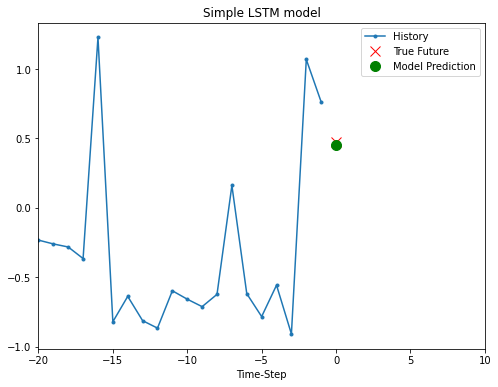

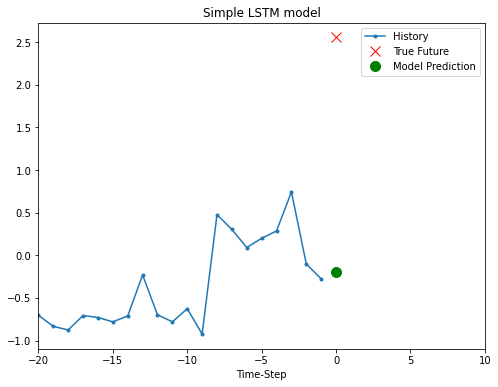

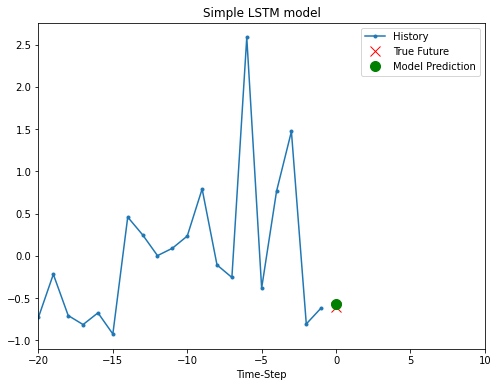

In [38]:
for x, y in val_rnn_cold.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()




---



#예측 2) 감기,눈병, 피부염, 천식 시계열 예측

In [9]:
features_considered = ['Cold','Eye','Asthma','Dermatitis']

In [10]:
features = df[features_considered]
features.index = df['Date']
features.head()

,Cold,Eye,Asthma,Dermatitis
Date,,,,
2014-01-01,53,2.0,7.0,4.0
2014-01-01,55,1.0,7.0,3.0
2014-01-01,120,7.0,11.0,2.0
2014-01-01,192,9.0,18.0,7.0
2014-01-01,165,6.0,17.0,5.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe02e8049d0>,
      dtype=object)

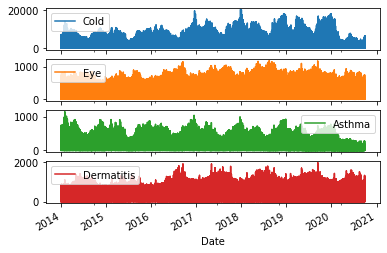

In [18]:
features.plot(subplots=True)


In [11]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
# 표준화
dataset = (dataset-data_mean)/data_std


In [12]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)


In [13]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)


In [14]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))


Single window of past history : (120, 4)


In [46]:
# Single window of past history : (120, 4)
# --> 120 : 5일 * 24시간
# --> 4 : 3개의 특성


In [15]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()


In [16]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')


In [17]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)


(256, 1)


In [50]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)


Epoch 1/10
200/200 [==============================] - 4s 13ms/step - loss: 0.6743 - val_loss: 0.7956
Epoch 2/10
200/200 [==============================] - 2s 11ms/step - loss: 0.5837 - val_loss: 0.7518
Epoch 3/10
200/200 [==============================] - 2s 11ms/step - loss: 0.5359 - val_loss: 0.7046
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 0.5096 - val_loss: 0.6747
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 0.5546 - val_loss: 0.6462
Epoch 6/10
200/200 [==============================] - 2s 12ms/step - loss: 0.5026 - val_loss: 0.6169
Epoch 7/10
200/200 [==============================] - 2s 11ms/step - loss: 0.5374 - val_loss: 0.5996
Epoch 8/10
200/200 [==============================] - 3s 13ms/step - loss: 0.4700 - val_loss: 0.6555
Epoch 9/10
200/200 [==============================] - 3s 13ms/step - loss: 0.5347 - val_loss: 0.6495
Epoch 10/10
200/200 [==============================] - 3s 13ms/step - loss: 0.4745 - val_lo

In [32]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()


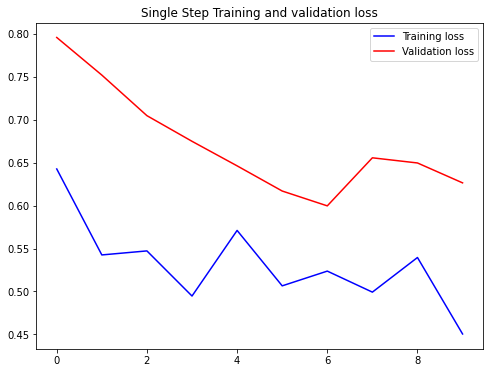

In [52]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')


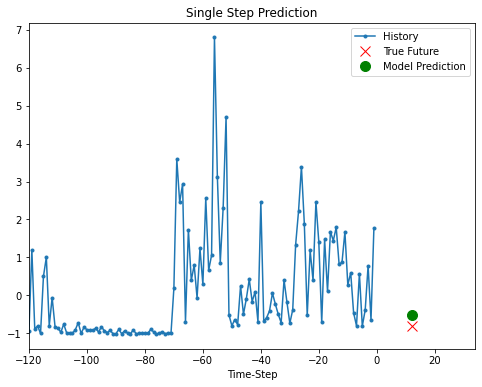

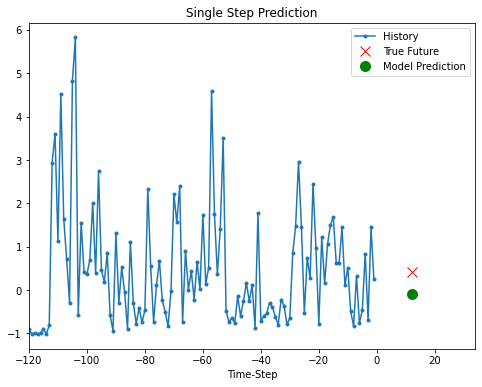

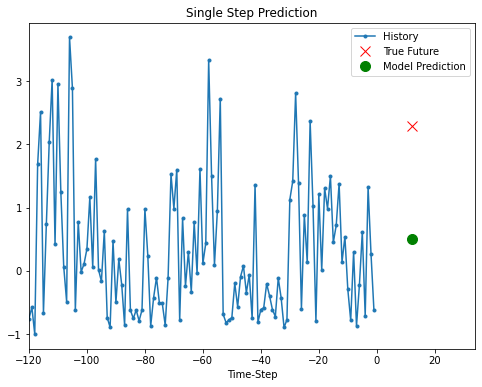

In [53]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()


In [18]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)


In [19]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))


Single window of past history : (120, 4)

 Target temperature to predict : (72,)


In [20]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()


In [21]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()


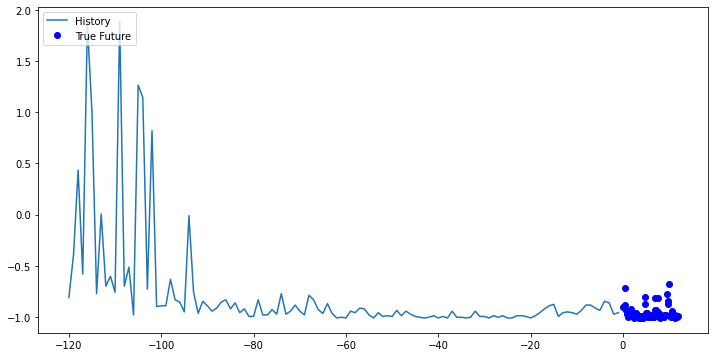

In [25]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))


In [26]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')


In [27]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)


(256, 72)


In [30]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)


Epoch 1/10
200/200 [==============================] - 58s 273ms/step - loss: 0.6775 - val_loss: 0.7376
Epoch 2/10
200/200 [==============================] - 54s 271ms/step - loss: 0.5628 - val_loss: 0.7118
Epoch 3/10
200/200 [==============================] - 55s 274ms/step - loss: 0.5233 - val_loss: 0.6724
Epoch 4/10
200/200 [==============================] - 55s 275ms/step - loss: 0.5074 - val_loss: 0.6626
Epoch 5/10
200/200 [==============================] - 55s 273ms/step - loss: 0.5593 - val_loss: 0.6353
Epoch 6/10
200/200 [==============================] - 54s 271ms/step - loss: 0.5070 - val_loss: 0.6090
Epoch 7/10
200/200 [==============================] - 60s 298ms/step - loss: 0.5609 - val_loss: 0.6010
Epoch 8/10
200/200 [==============================] - 60s 300ms/step - loss: 0.4837 - val_loss: 0.6474
Epoch 9/10
200/200 [==============================] - 60s 301ms/step - loss: 0.5199 - val_loss: 0.6369
Epoch 10/10
200/200 [==============================] - 60s 299ms/step - l

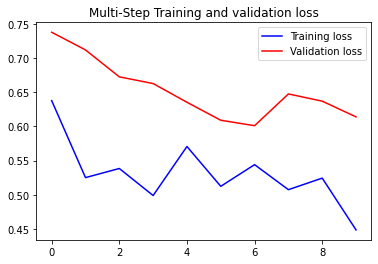

In [33]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

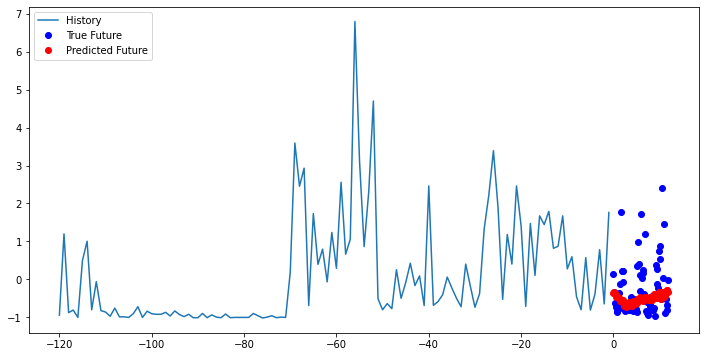

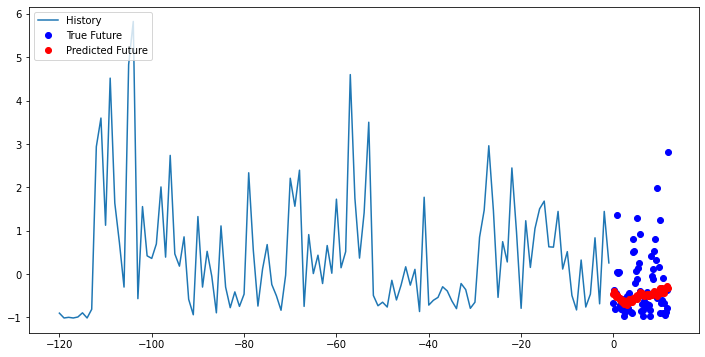

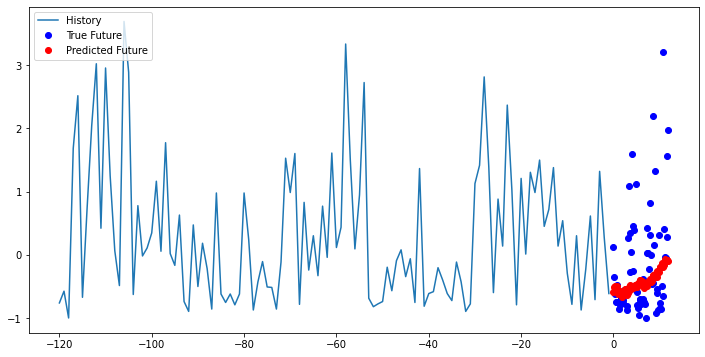

In [34]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])
